# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [12]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [13]:
from src.core.models.xgboost import XgboostModel
import pandas as pd


model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_133708_all/model_0.pickle'
)


feature_importance = model.feature_importance
features_model = list(feature_importance["feature"][0:100].values)

drifted_features = [
    "fea_sum_dept_monthly_sales_roll_avg_12_months",
    "fea_dept_std_longevity_months",
    "fea_sum_dept_num_days_item_is_zero_sales",
    "fea_dept_avg_longevity_months",
    "fea_dept_price_avg_roll_avg_12_months",
    "fea_dept_max_days_since_last_sale",
    "fea_sum_cat_monthly_sales_roll_std_12_months",
    "fea_is_national_event_3m",
    "fea_dept_price_std_roll_std_12_months",
    "fea_dept_price_avg_roll_avg_3_months",
    "fea_item_vs_dept_price_ratio_min_roll_max_3_months",
    "fea_item_vs_dept_price_ratio_max_roll_std_12_months",
    "fea_item_vs_dept_price_ratio_min_roll_std_12_months",
    "fea_dept_price_std_roll_std_6_months",
    "fea_dept_price_std_roll_std_3_months",
    "fea_item_monthly_sales_roll_count_12_months",
    "feature_ratio_avg_sales_cultural_event_roll_count_12_months"
]

features = [fea for fea in features_model if fea not in drifted_features]

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_133708_all/model_0.pickle


In [14]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
    ctx_item_id,
    ctx_date_month,
    ctx_cat_id,
    ctx_dept_id,
    ctx_store_id,
    {','.join(config_loader.inventory_sim_required_fields)},
    {config_loader.target_col},
    {config_loader.benchmark_col},
    {','.join(features)}
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
        AND fea_item_longevity_months >=3
        AND is_stockout_prev_3_m = 0
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 92273 rows from custom query.


In [15]:
trained_model = main(features = features, loaded_df=df)
print("last error was 0.12694")

INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
/Users/anapreciado/Desktop/porygon-demand-forecasting/src/core/transformations/transformations.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_df[target_col] = np.log1p(loaded_df[target_col])
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


This is outlier threshold = 420.0
[0]	validation_0-quantile:0.21294	validation_1-quantile:0.21343
[1]	validation_0-quantile:0.17315	validation_1-quantile:0.17516
[2]	validation_0-quantile:0.14401	validation_1-quantile:0.14615
[3]	validation_0-quantile:0.12421	validation_1-quantile:0.12643
[4]	validation_0-quantile:0.10950	validation_1-quantile:0.11143
[5]	validation_0-quantile:0.09928	validation_1-quantile:0.10097
[6]	validation_0-quantile:0.09257	validation_1-quantile:0.09427
[7]	validation_0-quantile:0.08799	validation_1-quantile:0.08981
[8]	validation_0-quantile:0.08494	validation_1-quantile:0.08702
[9]	validation_0-quantile:0.08281	validation_1-quantile:0.08535
[10]	validation_0-quantile:0.08134	validation_1-quantile:0.08435
[11]	validation_0-quantile:0.08025	validation_1-quantile:0.08377
[12]	validation_0-quantile:0.07941	validation_1-quantile:0.08329
[13]	validation_0-quantile:0.07882	validation_1-quantile:0.08301
[14]	validation_0-quantile:0.07836	validation_1-quantile:0.08288
[

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_150759/model_0.pickle
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_150759
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260131_150759
            


last error was 0.12694


In [16]:
# 12799
# 12325

## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

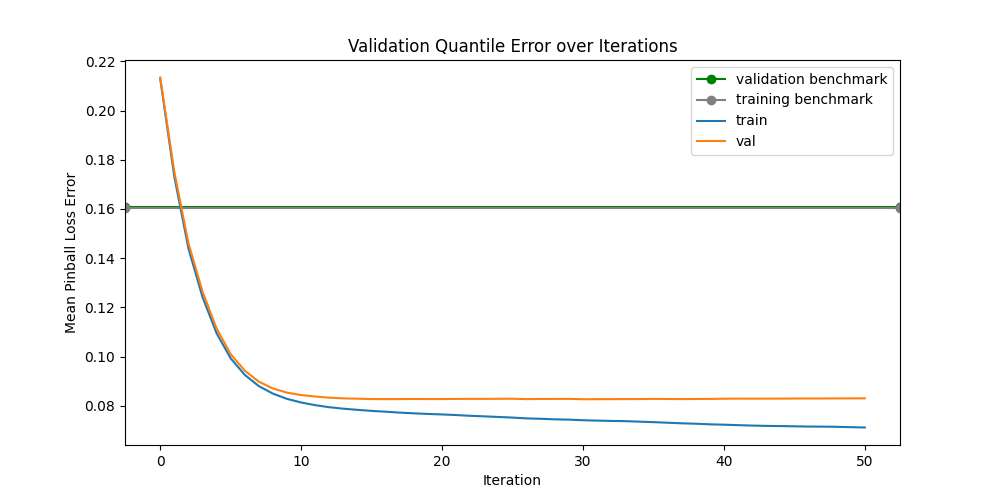

In [17]:
from IPython.display import Image, display
display(Image(trained_model.plot_bias_variance_tradeoff_path))

## 6. Evaluate Residuals

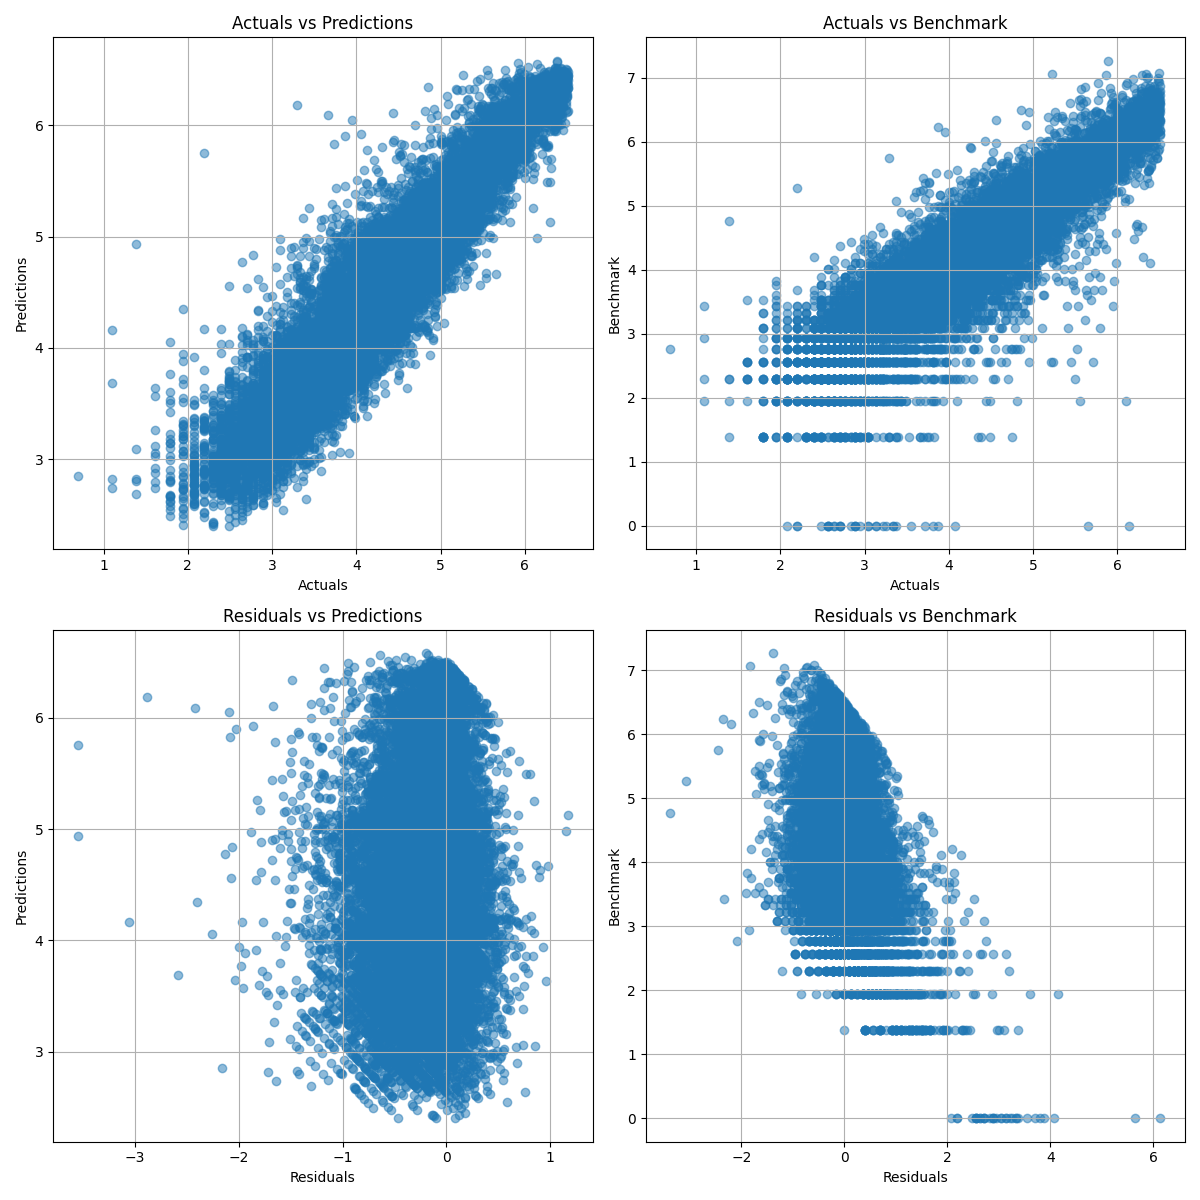

In [18]:
from IPython.display import Image, display
display(Image(trained_model.plot_residuals_paths))

## 8. Feature Importance

In [19]:
trained_model.feature_importance.head(20)

,feature,importance
0,fea_item_monthly_sales_roll_avg_12_months,100.0
1,fea_item_vs_dept_price_ratio_min,70.0
5,fea_item_vs_dept_price_ratio_avg_roll_std_12_m...,69.0
4,feature_avg_sales_not_snap_ca,67.0
2,fea_item_monthly_sales_roll_std_12_months,63.0
6,fea_item_monthly_sales_lag_1_months,54.0
3,feature_ratio_avg_sales_gift_driven_event_roll...,51.0
34,fea_ratio_item_dept_days_since_last_saleq75,48.0
8,fea_item_monthly_sales_roll_coeffvar_6_months,48.0
24,feature_ratio_avg_sales_snap_ca_roll_std_12_mo...,46.0


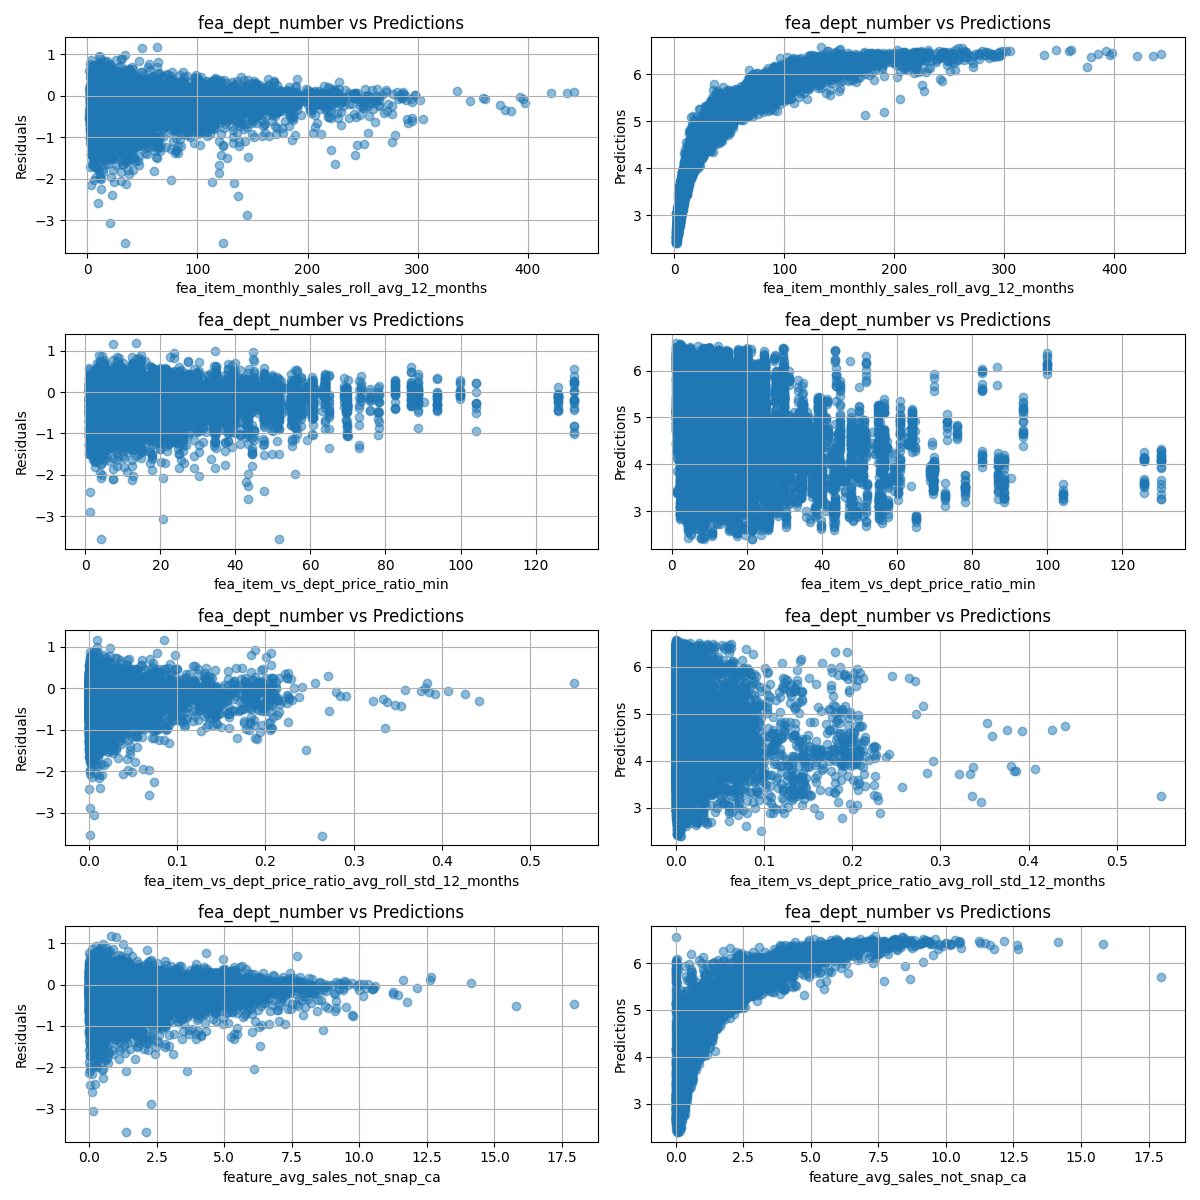

In [20]:
from IPython.display import Image, display
display(Image(trained_model._plot_importance_path))